In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

from evaluation import evaluate_model
from preprocessing import run_feature_engineering
from sklearn import preprocessing

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

sns.set_theme(
    style="whitegrid",       # Background style ("whitegrid", "darkgrid", etc.)
    palette="deep",          # Default color palette ("deep", "muted", "bright", etc.)
    font="sans-serif",       # Font family
    font_scale=1.1,          # Scale font size slightly
    rc={"figure.figsize": (8, 5)}  # Default figure size
)

c:\Users\Ahmed Osama\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_path = Path("../datasets")

train_identity = pd.read_csv(dataset_path / "train_identity.csv")
train_tx = pd.read_csv(dataset_path / "train_transaction.csv")

test_identity = pd.read_csv(dataset_path / "test_identity.csv")
test_tx = pd.read_csv(dataset_path / "test_transaction.csv")

In [3]:
train_all_cols = pd.merge(train_tx, train_identity, on='TransactionID', how='left')
test_all_cols = pd.merge(train_tx, train_identity, on='TransactionID', how='left')

X =  train_all_cols.drop(columns=['isFraud'])
y = train_all_cols['isFraud']

In [4]:
print(f"X_shape: {X.shape}")

X_shape: (590540, 433)


In [5]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42
)

In [6]:
def feature_engineering(X_train, X_test, null_threshold=0.96, unique_val_threshold=0.96, 
                       drop_transaction_dt=True, fill_na_value=-999, verbose=True):
    """
    Performs feature engineering on the training and test datasets.
    """
    # Create copies to avoid modifying the original dataframes
    X_train_processed = X_train.copy()
    X_test_processed = X_test.copy()
    
    # Find columns with too many null values
    many_null_cols = [col for col in X_train_processed.columns 
                      if X_train_processed[col].isnull().sum() / X_train_processed.shape[0] > null_threshold]
    many_null_cols_X_test = [col for col in X_test_processed.columns 
                            if X_test_processed[col].isnull().sum() / X_test_processed.shape[0] > null_threshold]
    
    # Find columns with a dominant value
    big_top_value_cols = [col for col in X_train_processed.columns 
                         if X_train_processed[col].value_counts(dropna=False, normalize=True).values[0] > unique_val_threshold]
    big_top_value_cols_X_test = [col for col in X_test_processed.columns 
                               if X_test_processed[col].value_counts(dropna=False, normalize=True).values[0] > unique_val_threshold]
    
    # Combine all columns to drop
    cols_to_drop = list(set(many_null_cols + many_null_cols_X_test + big_top_value_cols + big_top_value_cols_X_test))
    
    if verbose:
        print(f"Dropping {len(cols_to_drop)} low-information columns")
        print(cols_to_drop)
    
    # Drop low-information columns
    X_train_processed = X_train_processed.drop(cols_to_drop, axis=1)
    X_test_processed = X_test_processed.drop(cols_to_drop, axis=1)
    
    # Drop TransactionDT if specified
    if drop_transaction_dt and 'TransactionDT' in X_train_processed.columns:
        X_train_processed.drop('TransactionDT', axis=1, inplace=True)
        X_test_processed.drop('TransactionDT', axis=1, inplace=True)
    
    if verbose:
        print(f"Train shape after dropping columns: {X_train_processed.shape}")
        print(f"Test shape after dropping columns: {X_test_processed.shape}")
    
    # Label Encoding for categorical features
    for f in X_train_processed.columns:
        if X_train_processed[f].dtype=='object' or X_test_processed[f].dtype=='object': 
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(X_train_processed[f].values) + list(X_test_processed[f].values))
            X_train_processed[f] = lbl.transform(list(X_train_processed[f].values))
            X_test_processed[f] = lbl.transform(list(X_test_processed[f].values)) 
    
    # Fill missing values
    X_train_processed = X_train_processed.fillna(fill_na_value)
    X_test_processed = X_test_processed.fillna(fill_na_value)
    
    if verbose:
        print("Feature engineering completed")
    
    return X_train_processed, X_test_processed

In [7]:
# X_train, X_val, X_test = run_feature_engineering(X_train, X_val, X_test)

In [8]:
X_train, X_test = feature_engineering(
    X_train, 
    X_test,
    null_threshold=0.96,
    unique_val_threshold=0.96,
    drop_transaction_dt=True,
    fill_na_value=-999,
    verbose=True
)

Dropping 32 low-information columns
['V115', 'V311', 'V107', 'C3', 'V121', 'id_26', 'V117', 'id_27', 'V109', 'V116', 'id_08', 'V111', 'id_25', 'V123', 'V305', 'V286', 'V114', 'V122', 'V113', 'id_21', 'V301', 'id_22', 'id_23', 'V118', 'V300', 'V119', 'V120', 'id_07', 'V108', 'id_24', 'V110', 'V112']
Train shape after dropping columns: (377945, 400)
Test shape after dropping columns: (118108, 400)
Feature engineering completed


In [9]:
# from imblearn.over_sampling import KMeansSMOTE

# print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
# print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

# sm = KMeansSMOTE(random_state=99, sampling_strategy = 0.15,  k_neighbors = 10,cluster_balance_threshold = 0.02, n_jobs=4)
# X_train_new, y_train_new = sm.fit_resample(X_train, y_train.ravel())

# X_train_new = pd.DataFrame(X_train_new)
# X_train_new.columns = X_train.columns
# y_train_new = pd.DataFrame(y_train_new)

# print('After OverSampling, the shape of X_train_new: {}'.format(X_train_new.shape))
# print('After OverSampling, the shape of y_train_new: {} \n'.format(y_train_new.shape))

# print("After OverSampling, counts of label '1': {}".format(sum(y_train==1)))
# print("After OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

# X_train = X_train_new
# y_train = y_train_new

In [10]:
for name, X in zip(['Train', 'Validation', 'Test'], [X_train, X_val, X_test]):
    unique_dtypes = X.dtypes.unique()
    print(f"{name} unique dtypes: {list(unique_dtypes)}")

Train unique dtypes: [dtype('int64'), dtype('float64')]
Validation unique dtypes: [dtype('int64'), dtype('float64'), dtype('O')]
Test unique dtypes: [dtype('int64'), dtype('float64')]


In [11]:
def evaluate_random_forest_estimators(X_train, y_train, X_val, y_val, estimator_range):
    scores = []

    for n in estimator_range:
        rf = RandomForestClassifier(n_estimators=n, random_state=42, n_jobs=-1)
        rf.fit(X_train, y_train)

        y_val_pred_proba = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_val_pred_proba)
        scores.append(auc)
        print(f"n_estimators={n} => AUC: {auc:.4f}")

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(estimator_range, scores, marker='o')
    plt.title('Random Forest AUC vs. n_estimators')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Validation AUC')
    plt.grid(True)
    plt.show()

    return scores


In [12]:
# def print_column_ranges(X_train, X_val, X_test):
#     print("Column Ranges:")
#     for col in X_train.columns:
#         min_val = min(X_train[col].min(), X_val[col].min(), X_test[col].min())
#         max_val = max(X_train[col].max(), X_val[col].max(), X_test[col].max())
#         print(f"{col}: Min = {min_val}, Max = {max_val}")

# # Call the function assuming X_train, X_val, X_test are defined
# print_column_ranges(X_train, X_val, X_test)

In [13]:
# estimator_range = range(10, 210, 20) 
# scores = evaluate_random_forest_estimators(X_train, y_train, X_val, y_val, estimator_range)

In [14]:
model = RandomForestClassifier(n_estimators=250, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=250, n_jobs=-1, random_state=42)

In [20]:
X_val, X_val = feature_engineering(X_val, X_val)

Dropping 32 low-information columns
['V115', 'V311', 'V107', 'C3', 'V121', 'id_26', 'V117', 'id_27', 'V109', 'V116', 'id_08', 'V111', 'id_25', 'V123', 'V305', 'V286', 'V114', 'V122', 'V113', 'id_21', 'V301', 'id_22', 'id_23', 'V118', 'V300', 'V119', 'V120', 'id_07', 'V108', 'id_24', 'V110', 'V112']
Train shape after dropping columns: (94487, 400)
Test shape after dropping columns: (94487, 400)
Feature engineering completed



Validation Metrics:
AUC: 0.9324
Accuracy: 0.9796
Precision: 0.9412
Recall: 0.4456
F1 Score: 0.6048
Log Loss: 0.0782
Brier Score: 0.0172
Average Precision: 0.7099

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     91181
           1       0.94      0.45      0.60      3306

    accuracy                           0.98     94487
   macro avg       0.96      0.72      0.80     94487
weighted avg       0.98      0.98      0.98     94487

Confusion Matrix:
[[91089    92]
 [ 1833  1473]]

Test Metrics:
AUC: 0.9304
Accuracy: 0.9792
Precision: 0.9403
Recall: 0.4341
F1 Score: 0.5939
Log Loss: 0.0961
Brier Score: 0.0172
Average Precision: 0.7115

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.94      0.43      0.59      4133

    accuracy                           0.98    118108
   macro avg       0.96      0.72     

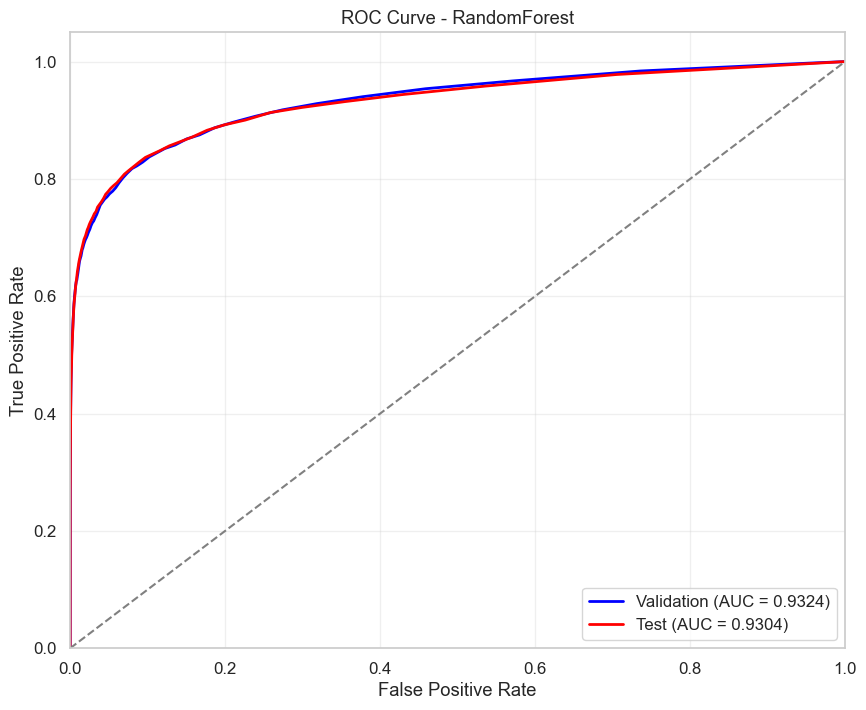

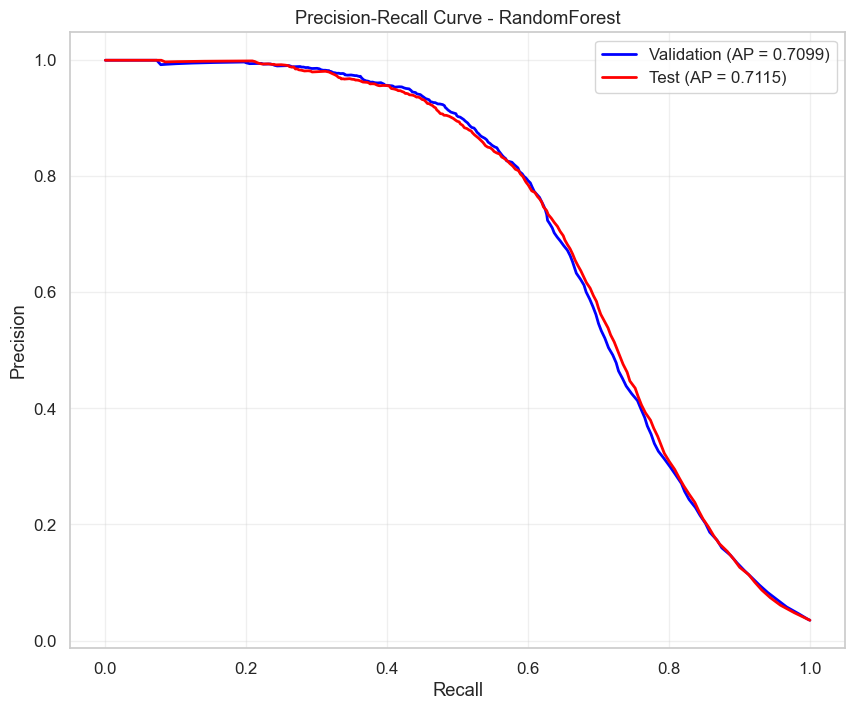

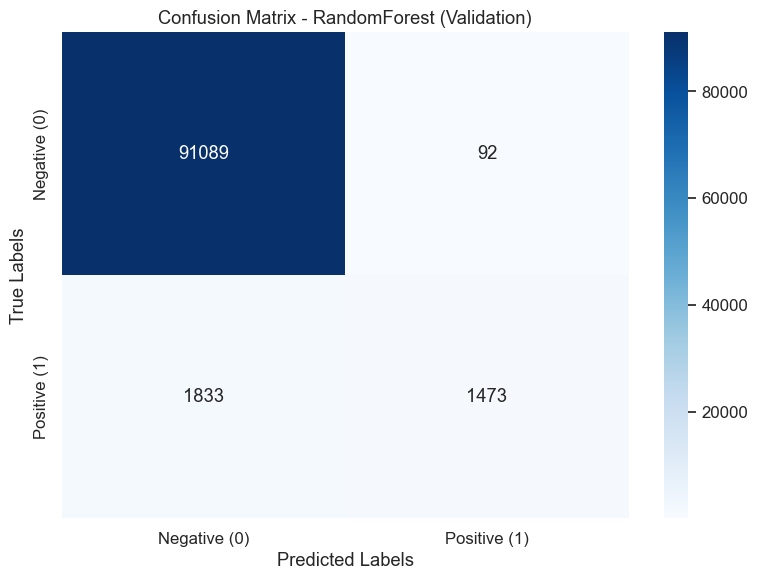

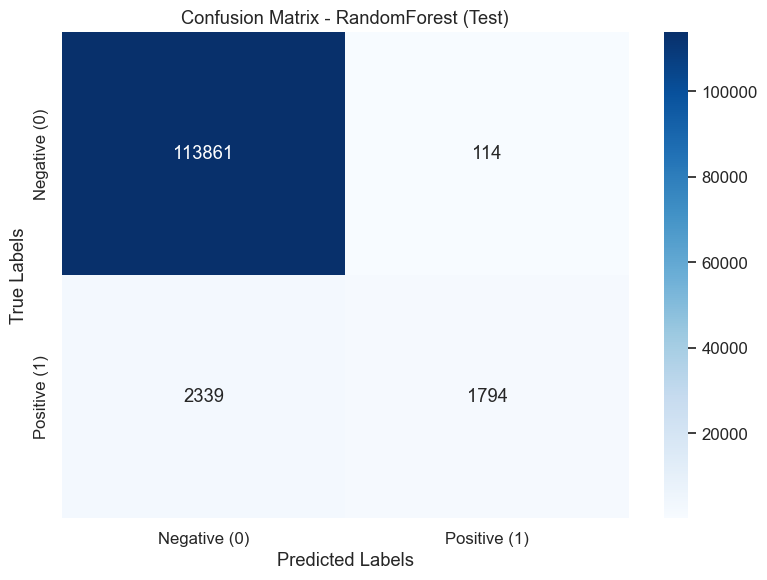

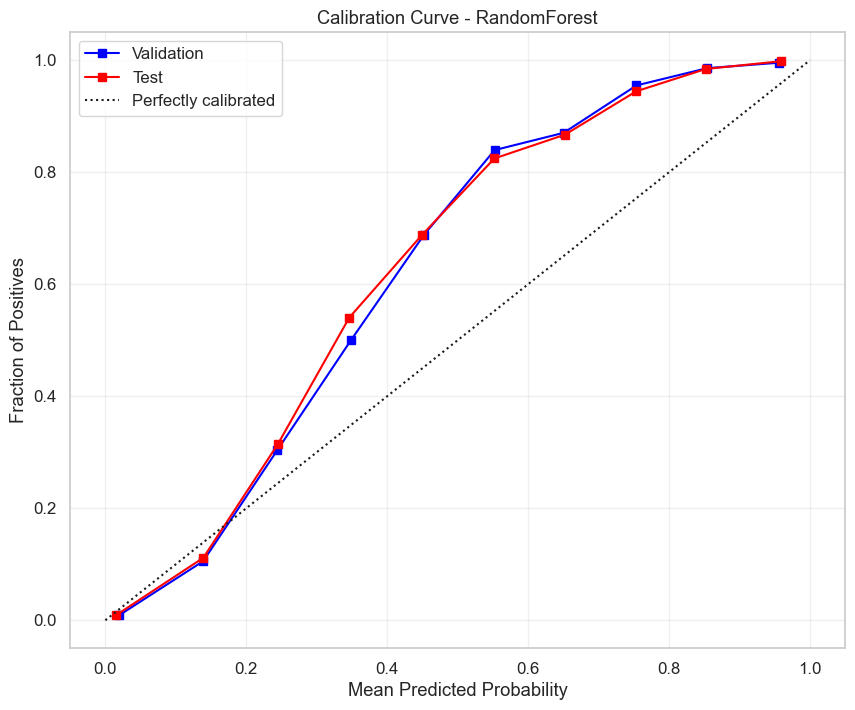

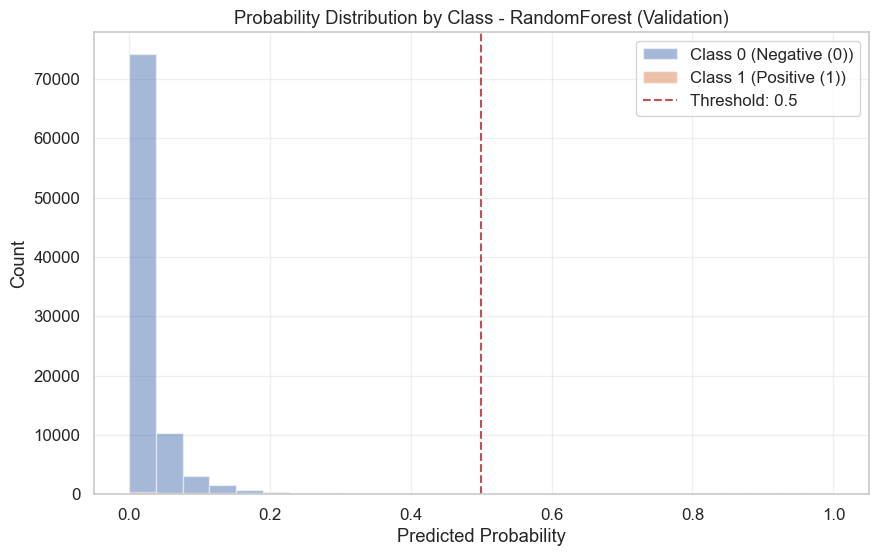

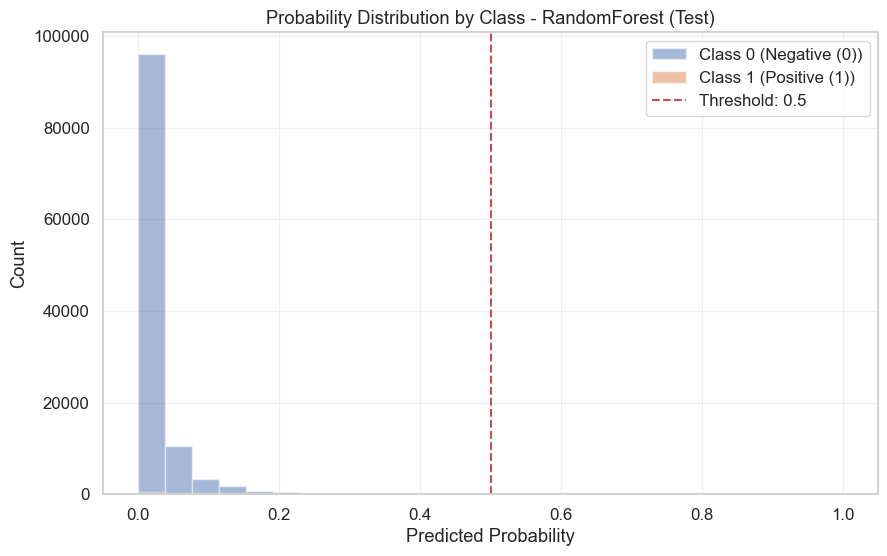

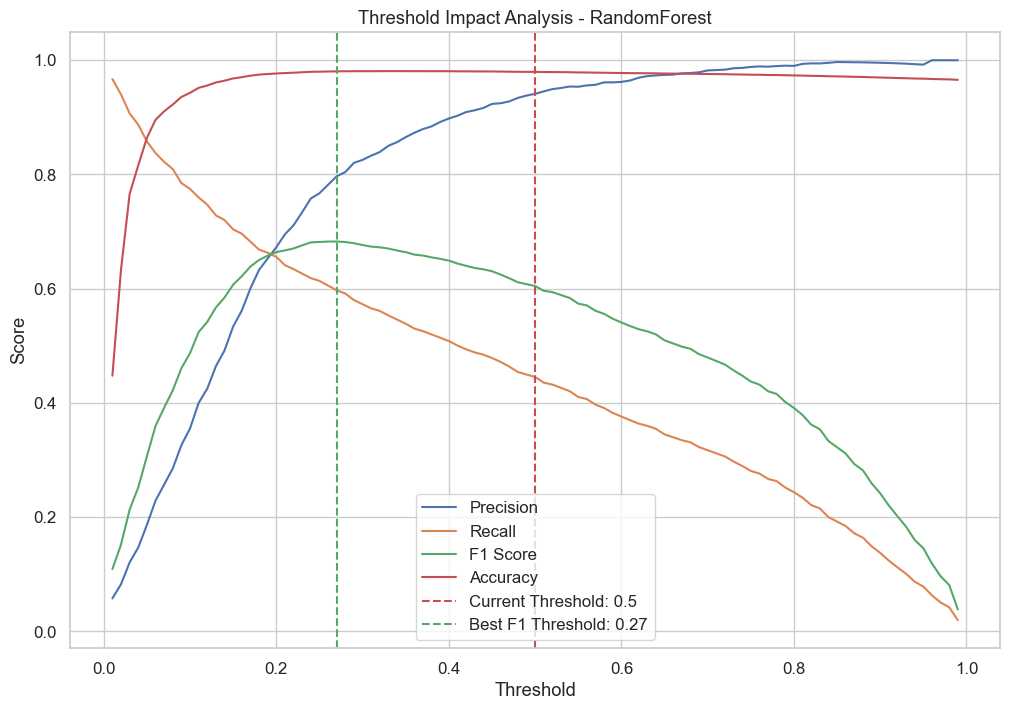

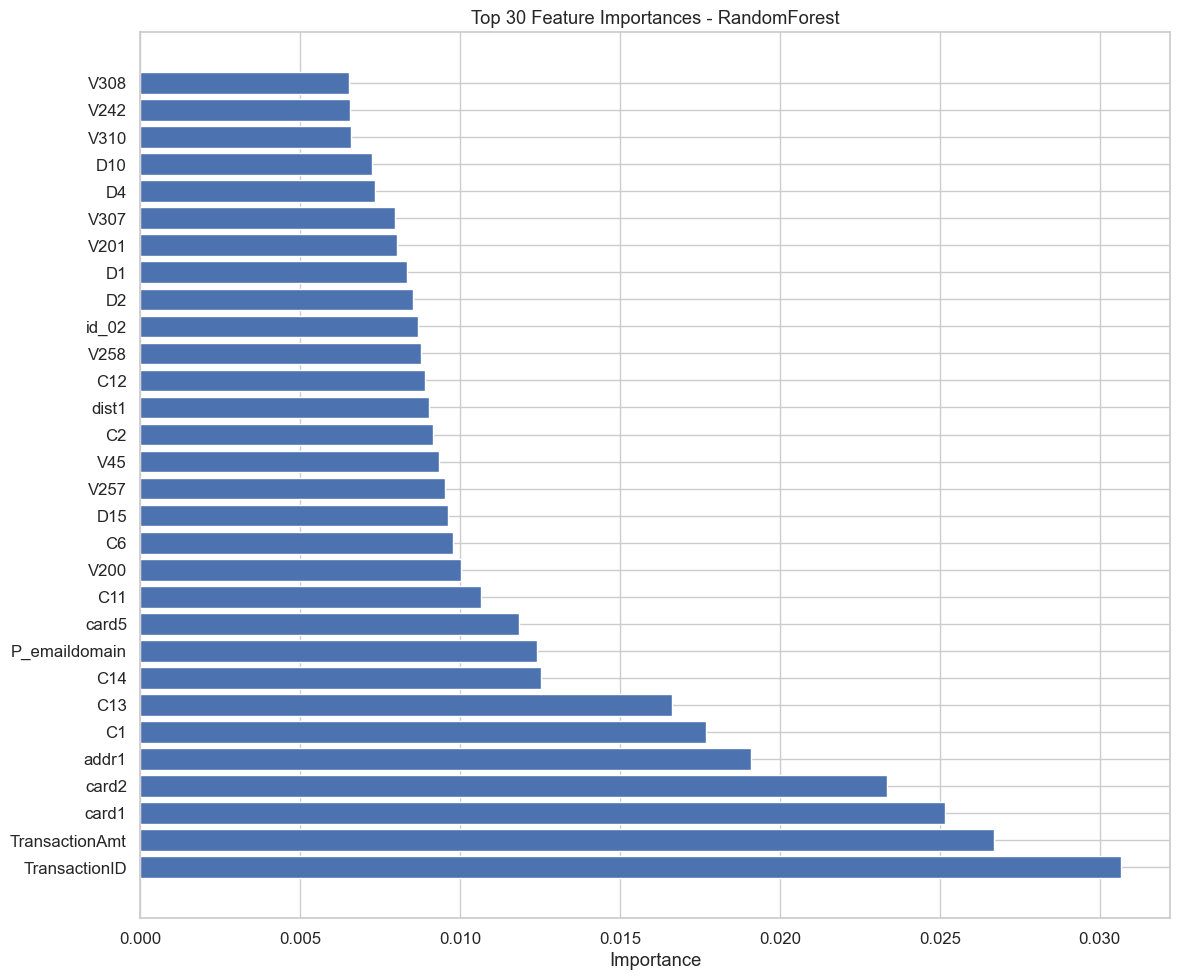

{'validation': {'auc': np.float64(0.9323688582477035),
  'accuracy': 0.9796268269709061,
  'precision': 0.9412140575079873,
  'recall': 0.4455535390199637,
  'f1': 0.6048039416957504,
  'log_loss': 0.0782367740339319,
  'brier_score': np.float64(0.017220806248478625),
  'average_precision': np.float64(0.7099308584412993),
  'confusion_matrix': array([[91089,    92],
         [ 1833,  1473]]),
  'classification_report': {'0': {'precision': 0.980273778007361,
    'recall': 0.9989910178655641,
    'f1-score': 0.989543896623086,
    'support': 91181.0},
   '1': {'precision': 0.9412140575079873,
    'recall': 0.4455535390199637,
    'f1-score': 0.6048039416957504,
    'support': 3306.0},
   'accuracy': 0.9796268269709061,
   'macro avg': {'precision': 0.9607439177576742,
    'recall': 0.7222722784427639,
    'f1-score': 0.7971739191594182,
    'support': 94487.0},
   'weighted avg': {'precision': 0.9789071197795527,
    'recall': 0.9796268269709061,
    'f1-score': 0.9760822533177661,
    '

In [21]:
evaluate_model(
    model,
    X_val,
    y_val,
    X_test,
    y_test,
    threshold=0.5,
    model_name="RandomForest",
    is_lightgbm=False
)